# Installations

In [ ]:
pip install -q "mujoco>=3.1.2" "gymnasium[mujoco]>=0.29.1" glfw
%pip uninstall -y box2d-py swig box2d
%pip install -U pip setuptools wheel
%pip install "box2d==2.3.10"
%pip install "gymnasium>=1.0" pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 57.9 MB/s  0:00:00


# Networks (Policy + Value)

**Goal.** Define a single Actor–Critic module that works for both discrete and continuous Gymnasium tasks.

**Design**
- Two MLPs with 64-unit Tanh layers for actor and critic.
- Orthogonal initialization for stable PPO-style training.
- Critic head: scalar value $V_\theta(s) \in \mathbb{R}$.
- Actor head:
  - **Discrete:** logits $\in \mathbb{R}^{|\mathcal{A}|}$ → `Categorical(logits=...)`.
  - **Continuous:** mean $\mu_\phi(s) \in \mathbb{R}^{A}$ and learned diagonal $\log\sigma \in \mathbb{R}^{A}$; distribution $\mathcal{N}\!\left(\mu_\phi(s), \operatorname{diag}(\sigma^2)\right)$ implemented via `MultivariateNormal(loc=μ, scale_tril=diag(σ))`.

**Interfaces**
- `get_value(x) -> Tensor`: returns $V(s)$ for input `x` shaped `[B, obs_dim]` (`float32`).
- `get_action_and_value(x, action=None) -> (action, log_prob, entropy, value)`  
  - If `action is None`, sample from the policy; otherwise evaluate given `action`.
  - Shapes:
    - Discrete `action`: `[B]`
    - Continuous `action`: `[B, A]`
    - `log_prob`, `entropy`: `[B]`
    - `value`: `[B, 1]`

**Conventions**
- Inputs are flattened: `obs_dim = prod(observation_space.shape)`.
- Orthogonal init gains:
  - Hidden layers: $\sqrt{2}$
  - Value head: $1.0$
  - Policy heads: $0.01$
- Continuous covariance uses a **proper** scale matrix: `scale_tril = diag(σ)`, not raw `σ` as the covariance.

**Summary**
- One module supports both heads.
- Discrete uses categorical logits; continuous uses Gaussian with diagonal covariance.
- API returns actions, log-probs, entropies, and values needed by PPO/VPG loops.

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal, Categorical
import gymnasium as gym
import numpy as np

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    """Orthogonal init commonly used in PPO for stable learning."""
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer

class ActorCritic(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.is_continuous = isinstance(envs.single_action_space, gym.spaces.Box)
        obs_dim = int(np.array(envs.single_observation_space.shape).prod())

        # Critic: V(s)
        self.critic = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )

        # Actor backbone
        self.actor = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
        )

        if self.is_continuous:
            act_dim = int(np.prod(envs.single_action_space.shape))
            self.actor_mean = layer_init(nn.Linear(64, act_dim), std=0.01)
            # learnable diagonal log-std (broadcasted across batch)
            self.actor_logstd = nn.Parameter(torch.zeros(1, act_dim))
        else:
            n_actions = envs.single_action_space.n
            self.actor_logits = layer_init(nn.Linear(64, n_actions), std=0.01)

    def get_value(self, x: torch.Tensor) -> torch.Tensor:
        """State value V(s). Shape: [B, 1]."""
        return self.critic(x)

    def get_action_and_value(self, x: torch.Tensor, action: torch.Tensor | None = None):
        """
        Sample (or evaluate) action, and return (action, log_prob, entropy, value).
        Works for both discrete and continuous action spaces.
        """
        h = self.actor(x)

        if self.is_continuous:
            mean = self.actor_mean(h)                           # [B, A]
            logstd = self.actor_logstd.expand_as(mean)          # [B, A]
            std = torch.exp(logstd)
            # Correct parametrization: σ on diagonal via scale_tril
            dist = MultivariateNormal(loc=mean, scale_tril=torch.diag_embed(std))
        else:
            logits = self.actor_logits(h)                       # [B, N]
            dist = Categorical(logits=logits)

        if action is None:
            action = dist.sample()

        log_prob = dist.log_prob(action)                        # [B]
        entropy = dist.entropy()                                # [B]
        value = self.critic(x)                                  # [B, 1]
        return action, log_prob, entropy, value

#Rollout Buffer (GAE + Minibatching)

**Goal.** Hold vectorized rollouts, compute GAE$(\lambda)$ returns, and yield shuffled mini-batches for PPO updates.

**Layout**
Let $T$ = `num_steps`, $E$ = `num_envs`, $A$ = `action_dim`.

**Stored tensors**
- `obs` — shape `[T, E, *]`, `float32`
- `rewards` — `[T, E]`, `float32`
- `dones` — `[T, E]`, `float32` in `{0,1}`
- `values` — `[T, E]`, `float32` (critic $V(s)$)
- `logprobs` — `[T, E]`, `float32`
- `actions`  
  - Discrete → `LongTensor` `[T, E]`  
  - Continuous → `FloatTensor` `[T, E, A]`

**APIs**
- `add(obs, action, logprob, reward, done, value)`  
  Append one **vectorized** step (all $E$ envs). `value` shaped `[E]`.
- `compute_returns_and_advantages(last_value, gamma, gae_lambda)`  
  Backward pass over time to compute GAE$(\lambda)$. Caches `self.advantages` and `self.returns` and returns `(returns, advantages)`, both `[T, E]`. `last_value` is $V(s_T)$ per env, shape `[E]`.
- `get_batch(batch_size)`  
  Flatten time×env to `T·E`, shuffle, and yield mini-batches:  
  `(obs_mb, actions_mb, logprobs_mb, advantages_mb, returns_mb, values_mb)`.
- `reset()`  
  Rewind write pointer `ptr = 0` after each PPO update.

**Data flow**
1. Collect $T$ steps: call `add(...)` each step.
2. After rollout: `compute_returns_and_advantages(...)`.
3. For several epochs: iterate `get_batch(batch_size)` to feed the optimizer.
4. `reset()` and start the next rollout.

**Shapes and conventions**
- Advantages/returns are **not** normalized here; PPO may normalize before loss.
- `dones` gate bootstrapping via `nonterminal = 1 - done`.
- Continuous actions stored as `[E, A]`; discrete as `[E]`. The training loop must pass correctly shaped tensors to `add()`.

**Gotchas**
- Keep shuffle indices on the **same device** as storage; mixing CPU indices with CUDA tensors errors.
- Ensure all inputs to `add(...)` are already batched over $E$.

**Outputs**
- Populated buffers for one rollout.
- Cached advantages and returns for PPO loss.
- A minibatch iterator for efficient SGD.

In [ ]:
class RolloutBuffer:
    def __init__(self, num_steps, num_envs, obs_space, action_space, device):
        self.num_steps = num_steps
        self.num_envs = num_envs
        self.device = device

        # Storage
        self.obs      = torch.zeros((num_steps, num_envs) + obs_space.shape, device=device, dtype=torch.float32)
        self.rewards  = torch.zeros((num_steps, num_envs), device=device, dtype=torch.float32)
        self.dones    = torch.zeros((num_steps, num_envs), device=device, dtype=torch.float32)
        self.values   = torch.zeros((num_steps, num_envs), device=device, dtype=torch.float32)
        self.logprobs = torch.zeros((num_steps, num_envs), device=device, dtype=torch.float32)

        # Actions: dtype by space
        self.discrete = isinstance(action_space, gym.spaces.Discrete)
        if self.discrete:
            self.actions = torch.zeros((num_steps, num_envs), device=device, dtype=torch.long)
        else:
            self.actions = torch.zeros((num_steps, num_envs) + action_space.shape, device=device, dtype=torch.float32)

        # Filled by compute_returns_and_advantages()
        self.advantages = None
        self.returns    = None

        self.ptr = 0

    def add(self, obs, action, logprob, reward, done, value):
        """Append one step for all E envs."""
        if self.ptr >= self.num_steps:
            raise ValueError("RolloutBuffer is full.")
        self.obs[self.ptr]      = obs
        self.actions[self.ptr]  = action
        self.logprobs[self.ptr] = logprob
        self.rewards[self.ptr]  = reward
        self.dones[self.ptr]    = done
        self.values[self.ptr]   = value.view(-1)  # [E]
        self.ptr += 1

    def compute_returns_and_advantages(self, last_value, gamma, gae_lambda):
        """
        GAE(λ) over T steps for E parallel envs.
        Inputs:
          last_value: V(s_T) per env, shape [E]
        Outputs:
          returns, advantages: [T, E]
        """
        rewards = self.rewards
        values  = self.values
        dones   = self.dones

        T, E = rewards.shape
        adv = torch.zeros_like(rewards, device=self.device)
        last_gae = torch.zeros(E, device=self.device, dtype=rewards.dtype)

        next_v = last_value.view(E).to(self.device)
        for t in reversed(range(T)):
            nonterm = 1.0 - dones[t]                  # [E]
            if t < T - 1:
                next_v = values[t + 1]                # V(s_{t+1})
            delta = rewards[t] + gamma * next_v * nonterm - values[t]
            last_gae = delta + gamma * gae_lambda * nonterm * last_gae
            adv[t] = last_gae

        ret = adv + values
        # cache for training
        self.advantages = adv
        self.returns = ret
        return ret, adv

    def get_batch(self, batch_size):
        """Yield shuffled flattened mini-batches."""
        num_samples = self.num_steps * self.num_envs
        idx = torch.randperm(num_samples, device=self.device)

        flat_obs   = self.obs.reshape((num_samples,) + self.obs.shape[2:])
        flat_act   = self.actions.reshape((num_samples,) + (() if self.discrete else self.actions.shape[2:]))
        flat_logp  = self.logprobs.reshape(num_samples)
        flat_adv   = self.advantages.reshape(num_samples)
        flat_ret   = self.returns.reshape(num_samples)
        flat_val   = self.values.reshape(num_samples)

        for start in range(0, num_samples, batch_size):
            mb = idx[start:start + batch_size]
            yield (
                flat_obs[mb],
                flat_act[mb],
                flat_logp[mb],
                flat_adv[mb],
                flat_ret[mb],
                flat_val[mb],
            )

    def reset(self):
        """Rewind write pointer after an update."""
        self.ptr = 0


In [ ]:
import torch.optim as optim
class PPOAgent:
    def __init__(self, envs, device, lr, gamma, gae_lambda, update_epochs,
                 clip_coef, ent_coef, vf_coef, max_grad_norm, norm_adv, clip_vloss):

        self.device = device
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.update_epochs = update_epochs
        self.clip_coef = clip_coef
        self.ent_coef = ent_coef
        self.vf_coef = vf_coef
        self.max_grad_norm = max_grad_norm
        self.norm_adv = norm_adv
        self.clip_vloss = clip_vloss

        self.network = ActorCritic(envs).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr, eps=1e-5)

    def select_action(self, obs):
        """
        Selects an action based on the current observation.
        Used during the data collection phase.
        """
        with torch.no_grad():
            action, log_prob, _, value = self.network.get_action_and_value(obs)
        return action, log_prob, value

    def update(self, buffer):
        """
        Performs the PPO update using the data in the rollout buffer.
        """
        # Calculate GAE and returns
        returns, advantages = buffer.compute_returns_and_advantages(
            self.network.get_value(buffer.obs[-1]).detach(),
            self.gamma,
            self.gae_lambda
        )
        buffer.returns = returns
        buffer.advantages = advantages

        # --- Multi-epoch, mini-batch update loop ---
        for epoch in range(self.update_epochs):
            batch_generator = buffer.get_batch(batch_size=64) # Example batch size
            for batch in batch_generator:
                b_obs, b_actions, b_logprobs, b_advantages, b_returns, b_values = batch

                # Normalize advantages (a key implementation detail)
                if self.norm_adv:
                    b_advantages = (b_advantages - b_advantages.mean()) / (b_advantages.std() + 1e-8)

                # --- Calculate Losses ---
                _, new_logprob, entropy, new_value = self.network.get_action_and_value(b_obs, b_actions)
                logratio = new_logprob - b_logprobs
                ratio = torch.exp(logratio)

                # Policy Loss (L_CLIP)
                pg_loss1 = -b_advantages * ratio
                pg_loss2 = -b_advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value Loss (L_VF)
                new_value = new_value.view(-1)
                if self.clip_vloss:
                    v_loss_unclipped = (new_value - b_returns) ** 2
                    v_clipped = b_values + torch.clamp(new_value - b_values, -self.clip_coef, self.clip_coef)
                    v_loss_clipped = (v_clipped - b_returns) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()
                else:
                    v_loss = 0.5 * ((new_value - b_returns) ** 2).mean()

                # Entropy Loss
                entropy_loss = entropy.mean()

                # Total Loss
                loss = pg_loss - self.ent_coef * entropy_loss + self.vf_coef * v_loss

                # --- Backpropagation and Gradient Clipping ---
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)
                self.optimizer.step()

# Cell — PPO Agent (Policy Update Logic)

**Goal.** Implement PPO-Clip action selection and multi-epoch SGD over shuffled mini-batches.

**Responsibilities**
- Hyperparameters: `gamma`, `gae_lambda`, `update_epochs`, `clip_coef`, `ent_coef`, `vf_coef`, `max_grad_norm`, `norm_adv`, `clip_vloss`.
- Hold `ActorCritic` and an Adam optimizer.
- Provide:
  - `select_action(obs)` → sample action and return `(action, log_prob, V(s))`.
  - `update(buffer)` → compute GAE returns and optimize PPO losses.

**Data / Shapes**
- From `RolloutBuffer` after a rollout:  
  `obs[T,E,*]`, `actions[T,E{,A}]`, `logprobs[T,E]`, `rewards[T,E]`, `dones[T,E]`, `values[T,E]`.  
- `update()` flattens time×env to `T·E` and iterates `buffer.get_batch(batch_size)`.

**GAE + Returns**
- Compute once per rollout:


In [ ]:
import gymnasium as gym
import torch
import numpy as np
import time
import argparse
import matplotlib.pyplot as plt
import math
from collections import deque

def run_ppo(
    env_id="CartPole-v1",
    total_timesteps=50_000,
    lr=2.5e-4,
    num_envs=4,
    num_steps=128,
    gamma=0.99,
    gae_lambda=0.95,
    update_epochs=4,
    clip_coef=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    norm_adv=True,
    clip_vloss=True,
    anneal_lr=True,
    seed=42,
    eval_every_updates: int | None = 5,
    eval_episodes: int = 5,
):
    print(f"--- Starting PPO training for {env_id} ---")

    np.random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    envs = gym.vector.SyncVectorEnv([lambda: gym.make(env_id) for _ in range(num_envs)])
    assert isinstance(envs.single_action_space, (gym.spaces.Discrete, gym.spaces.Box))

    agent = PPOAgent(
        envs=envs,
        device=device,
        lr=lr,
        gamma=gamma,
        gae_lambda=gae_lambda,
        update_epochs=update_epochs,
        clip_coef=clip_coef,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        max_grad_norm=max_grad_norm,
        norm_adv=norm_adv,
        clip_vloss=clip_vloss,
    )

    buffer = RolloutBuffer(
        num_steps=num_steps,
        num_envs=num_envs,
        obs_space=envs.single_observation_space,
        action_space=envs.single_action_space,
        device=device,
    )

    global_step = 0
    start_time = time.time()
    next_obs, _ = envs.reset(seed=seed)
    next_obs = torch.tensor(next_obs, device=device, dtype=torch.float32)
    num_updates = total_timesteps // (num_envs * num_steps)
    steps_per_update = num_envs * num_steps
    window_updates = max(1, math.ceil(20_000 / steps_per_update))  # 20k-step window
    rolling = deque(maxlen=window_updates)


    training_history = []
    eval_history = []
    last_avg_return = float("nan")
    episode_returns = torch.zeros(num_envs, device=device)
    is_discrete = isinstance(envs.single_action_space, gym.spaces.Discrete)
    action_dim  = envs.single_action_space.n if is_discrete else envs.single_action_space.shape[0]


    for update in range(1, num_updates + 1):
        # anneal LR
        if anneal_lr:
            frac = 1.0 - (update - 1.0) / max(1, num_updates)
            lr_now = frac * lr
            for pg in agent.optimizer.param_groups:
                pg["lr"] = lr_now

        returns_this_update = []
      # anneal entropy bonus to 0 after 50k env steps
        if agent.ent_coef != 0.0 and global_step >= 50_000:
          agent.ent_coef = 0.0


        # rollout
        for step in range(num_steps):
            global_step += num_envs
            obs = next_obs

            action, log_prob, value = agent.select_action(obs)
            if is_discrete:
                # env expects (E,) int64 ; buffer stores [E]
                a_store = action.view(num_envs)
                a_env   = a_store.detach().cpu().numpy().astype(np.int64)
            else:
                # env expects (E,A) float32 ; buffer stores [E,A]
                a_store = action.view(num_envs, action_dim)
                a_env   = a_store.detach().cpu().numpy().astype(np.float32)

            next_obs_np, reward_np, terminated_np, truncated_np, info = envs.step(a_env)
            done_np = np.logical_or(terminated_np, truncated_np)

            lp_t = log_prob.view(-1).detach()
            v_t  = value.view(-1).detach()
            r_t  = torch.tensor(reward_np, device=device, dtype=torch.float32).view(-1)
            d_t  = torch.tensor(done_np,   device=device, dtype=torch.float32).view(-1)

            buffer.add(obs, a_store, lp_t, r_t, d_t, v_t)


            next_obs = torch.tensor(next_obs_np, device=device, dtype=torch.float32)

            # episodic returns from Gymnasium's final_info
            final_info_list = info.get("final_info", [])
            # if final_info_list:
            #     for fi in final_info_list:
            #         if fi is not None and "episode" in fi:
            #             returns_this_update.append(float(fi["episode"]["r"]))
            # accumulate per-env episodic returns
            episode_returns += r_t  # r_t is shape [E]

            # detect finished episodes and log their returns
            for i in range(num_envs):
                if done_np[i]:
                    ret_i = float(episode_returns[i].item())
                    returns_this_update.append(ret_i)
                    episode_returns[i] = 0.0


        # update policy
        agent.update(buffer)
        buffer.reset()

        # record avg episodic return for this update
        if len(returns_this_update) > 0:
            last_avg_return = float(np.mean(returns_this_update))
        training_history.append(last_avg_return)

        # periodic evaluation
        if eval_every_updates and (update % eval_every_updates == 0):
            eval_mean = eval_policy(agent, env_id, episodes=eval_episodes, seed=seed)
            eval_history.append((update, eval_mean))


        if env_id == "CartPole-v1" and not np.isnan(last_avg_return):
            rolling.append(last_avg_return)
            if len(rolling) == window_updates and np.mean(rolling) >= 475.0:
                print(f"Early stop at step {global_step}: rolling_mean={np.mean(rolling):.1f}")
                break


        # logging
        if update % 10 == 0 or update == num_updates:
            sps = int(global_step / max(1e-9, (time.time() - start_time)))
            print(f"Global step: {global_step}, Update: {update}/{num_updates}")
            if not np.isnan(last_avg_return):
                print(f"  Avg. Episodic Return: {last_avg_return:.2f}")
            print(f"SPS: {sps}")
            print("-" * 20)

    envs.close()
    print(f"--- Finished training for {env_id} ---")
    return training_history, eval_history



def plot_training_results(env_name, returns_history, steps_per_update):
    plt.figure(figsize=(10, 6))
    vals = []
    for r in returns_history:
        try:
            v = float(np.nanmean(np.asarray(r, dtype=np.float64)))
        except Exception:
            v = np.nan
        vals.append(v)

    valid = [(i, v) for i, v in enumerate(vals) if not np.isnan(v)]
    if not valid:
        print(f"No valid episodic returns were recorded for {env_name} to plot.")
        return

    idx, rets = zip(*valid)
    steps = np.array(idx) * steps_per_update
    plt.plot(steps, rets)
    plt.title(f'PPO Performance on {env_name}')
    plt.xlabel('Training Steps')
    plt.ylabel('Average Episodic Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--env-id", type=str, default="CartPole-v1")
    parser.add_argument("--total-timesteps", type=int, default=50_000)
    parser.add_argument("--lr", type=float, default=2.5e-4)
    parser.add_argument("--num-envs", type=int, default=4)
    parser.add_argument("--num-steps", type=int, default=128)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--gae-lambda", type=float, default=0.95)
    parser.add_argument("--update-epochs", type=int, default=4)
    parser.add_argument("--clip-coef", type=float, default=0.2)
    parser.add_argument("--ent-coef", type=float, default=0.01)
    parser.add_argument("--vf-coef", type=float, default=0.5)
    parser.add_argument("--max-grad-norm", type=float, default=0.5)
    parser.add_argument("--no-norm-adv", action="store_true")
    parser.add_argument("--no-clip-vloss", action="store_true")
    parser.add_argument("--no-anneal-lr", action="store_true")
    parser.add_argument("--seed", type=int, default=42)
    return parser.parse_args()


def eval_policy(agent, env_id, episodes=5, seed=0):
    import gymnasium as gym
    env = gym.make(env_id)
    is_discrete = isinstance(env.action_space, gym.spaces.Discrete)
    scores = []
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed+ep)
        done = False
        ret = 0.0
        while not done:
            o = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(agent.device)
            with torch.no_grad():
                act, _, _ = agent.select_action(o)  # no exploration noise expected
            if is_discrete:
                a = int(act.squeeze().cpu().item())                 # scalar int
            else:
                a = act.squeeze(0).cpu().numpy().astype(np.float32) # shape (A,)
            obs, r, term, trunc, _ = env.step(a)
            done = term or trunc
            ret += r
        scores.append(ret)
    env.close()
    return float(np.mean(scores))




def plot_training_and_eval(env_name, train_hist, eval_hist, steps_per_update):
    plt.figure(figsize=(10,6))
    # training curve
    valid = [(i, r) for i, r in enumerate(train_hist) if not np.isnan(r)]
    if valid:
        idx, rets = zip(*valid)
        steps = np.array(idx) * steps_per_update
        plt.plot(steps, rets, label="Train mean return")
    # eval markers
    if eval_hist:
        eval_updates, eval_means = zip(*eval_hist)
        eval_steps = np.array(eval_updates) * steps_per_update
        plt.plot(eval_steps, eval_means, marker='o', linestyle='--', label="Eval mean return")
    plt.title(f"PPO Performance on {env_name}")
    plt.xlabel("Training Steps")
    plt.ylabel("Average Episodic Return")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

## CARTPOLE-V1

--- Starting PPO training for CartPole-v1 ---
Global step: 20480, Update: 10/58
  Avg. Episodic Return: 468.25
SPS: 1219
--------------------
Global step: 40960, Update: 20/58
  Avg. Episodic Return: 413.00
SPS: 1286
--------------------
Global step: 61440, Update: 30/58
  Avg. Episodic Return: 500.00
SPS: 1323
--------------------
Early stop at step 77824: rolling_mean=475.2
--- Finished training for CartPole-v1 ---


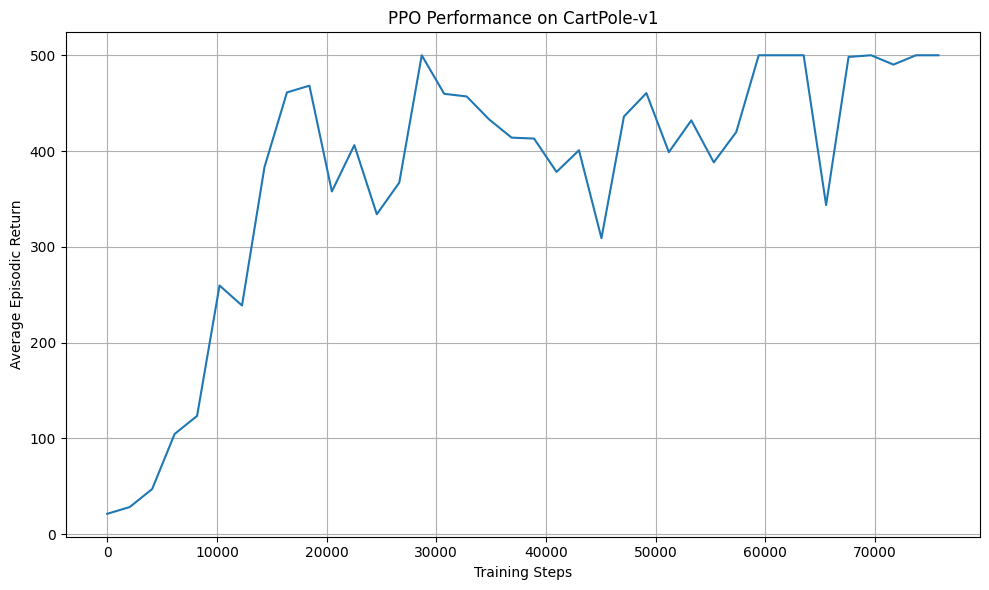

In [ ]:
if __name__ == "__main__":
    env = "CartPole-v1"
    run_params = {
        "env_id": env,
        "total_timesteps": 120_000,
        "lr": 7.5e-4,
        "num_envs": 4,         # stabler gradients
        "num_steps": 512,
        "update_epochs": 6,
        "clip_coef": 0.2,
        "ent_coef": 0.0,       # turn off exploration bonus
        "vf_coef": 0.5,
        "gamma": 0.995,        # helps long-horizon stability
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "clip_vloss": True,
        "norm_adv": True,
        "anneal_lr": True,
        "seed": 42,
    }
    history = run_ppo(**run_params)
    steps_per_update = run_params["num_envs"] * run_params["num_steps"]
    plot_training_results(env, history, steps_per_update)



# Acrobot-v1

--- Starting PPO training for Acrobot-v1 ---
Global step: 20480, Update: 10/73
  Avg. Episodic Return: -293.00
SPS: 998
--------------------
Global step: 40960, Update: 20/73
  Avg. Episodic Return: -122.25
SPS: 1002
--------------------
Global step: 61440, Update: 30/73
  Avg. Episodic Return: -121.47
SPS: 1016
--------------------
Global step: 81920, Update: 40/73
  Avg. Episodic Return: -115.50
SPS: 1018
--------------------
Global step: 102400, Update: 50/73
  Avg. Episodic Return: -92.68
SPS: 1027
--------------------
Global step: 122880, Update: 60/73
  Avg. Episodic Return: -81.75
SPS: 1022
--------------------
Global step: 143360, Update: 70/73
  Avg. Episodic Return: -89.38
SPS: 1025
--------------------
Global step: 149504, Update: 73/73
  Avg. Episodic Return: -92.55
SPS: 1024
--------------------
--- Finished training for Acrobot-v1 ---


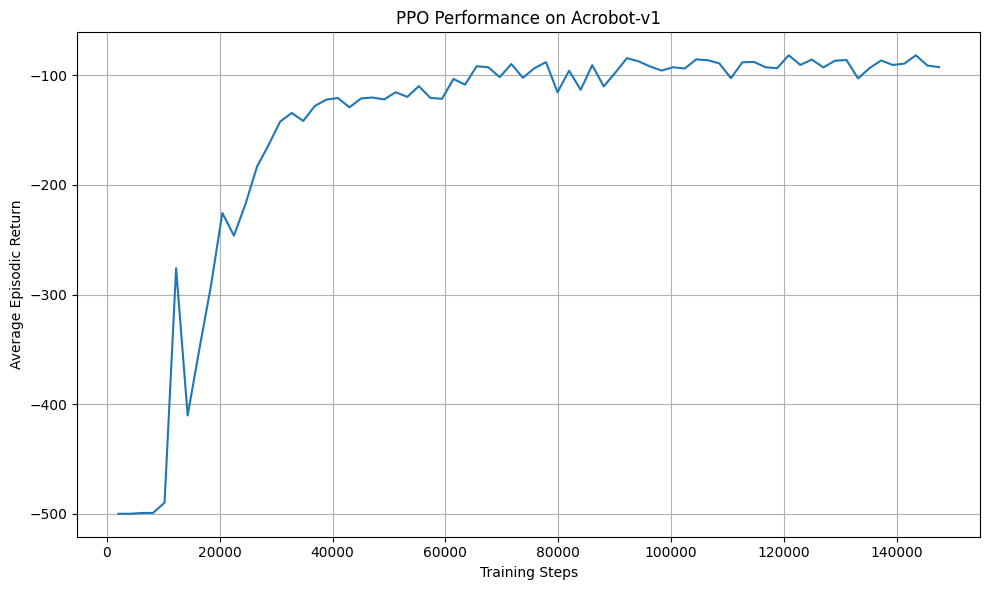

In [ ]:
if __name__ == "__main__":
    env = "Acrobot-v1"
    run_params = {
        "env_id": env,
        "total_timesteps": 150_000,
        "lr": 3e-4,
        "num_envs": 8,
        "num_steps": 256,             # batch = 2048
        "update_epochs": 10,          # more passes helps on sparse reward
        "clip_coef": 0.2,
        "ent_coef": 0.01,             # keep exploration
        "vf_coef": 0.5,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "clip_vloss": True,
        "norm_adv": True,
        "anneal_lr": True,
        "seed": 42,
    }
    history = run_ppo(**run_params)
    steps_per_update = run_params["num_envs"] * run_params["num_steps"]
    plot_training_results(env, history, steps_per_update)


# InvertedPendulum-v5

--- Starting PPO training for InvertedPendulum-v5 ---
Global step: 81920, Update: 10/36
  Avg. Episodic Return: 116.18
SPS: 799
--------------------
Global step: 163840, Update: 20/36
  Avg. Episodic Return: 616.13
SPS: 801
--------------------
Global step: 245760, Update: 30/36
  Avg. Episodic Return: 908.12
SPS: 796
--------------------
Global step: 294912, Update: 36/36
  Avg. Episodic Return: 1000.00
SPS: 786
--------------------
--- Finished training for InvertedPendulum-v5 ---


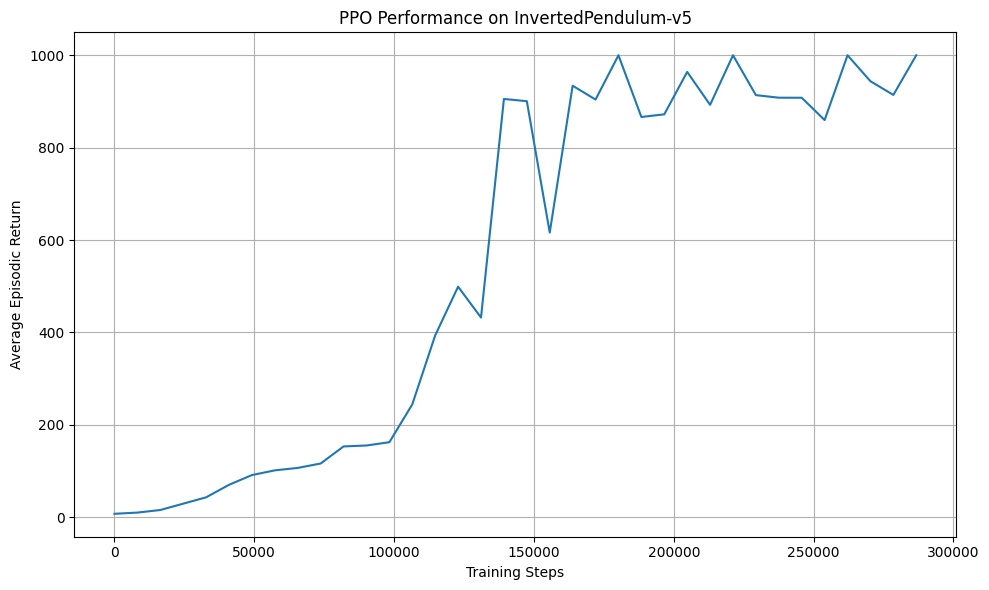

In [ ]:
if __name__ == "__main__":
    env = "InvertedPendulum-v5"
    run_params = {
        "env_id": env,
        "total_timesteps": 300_000,
        "lr": 3e-4,
        "num_envs": 4,
        "num_steps": 2048,          # batch = 8192
        "update_epochs": 10,
        "clip_coef": 0.2,
        "ent_coef": 0.0,            # continuous, easy control
        "vf_coef": 0.5,
        "gamma": 0.99,              # if wobble, try 0.995
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "clip_vloss": True,
        "norm_adv": True,
        "anneal_lr": True,
        "seed": 42,
        # if supported:
        # "num_minibatches": 32,     # 256 per minibatch
        # "target_kl": 0.02,
    }
    history = run_ppo(**run_params)
    steps_per_update = run_params["num_envs"] * run_params["num_steps"]
    plot_training_results(env, history, steps_per_update)


# HalfCheetah-v4

--- Starting PPO training for HalfCheetah-v4 ---


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Global step: 81920, Update: 10/366
  Avg. Episodic Return: -450.36
SPS: 640
--------------------
Global step: 163840, Update: 20/366
  Avg. Episodic Return: -322.59
SPS: 664
--------------------
Global step: 245760, Update: 30/366
  Avg. Episodic Return: -237.90
SPS: 659
--------------------
Global step: 327680, Update: 40/366
  Avg. Episodic Return: -136.39
SPS: 663
--------------------
Global step: 409600, Update: 50/366
  Avg. Episodic Return: 4.12
SPS: 660
--------------------
Global step: 491520, Update: 60/366
  Avg. Episodic Return: 222.72
SPS: 664
--------------------
Global step: 573440, Update: 70/366
  Avg. Episodic Return: 442.04
SPS: 668
--------------------
Global step: 655360, Update: 80/366
  Avg. Episodic Return: 598.34
SPS: 672
--------------------
Global step: 737280, Update: 90/366
  Avg. Episodic Return: 757.02
SPS: 674
--------------------
Global step: 819200, Update: 100/366
  Avg. Episodic Return: 803.30
SPS: 676
--------------------
Global step: 901120, Update:

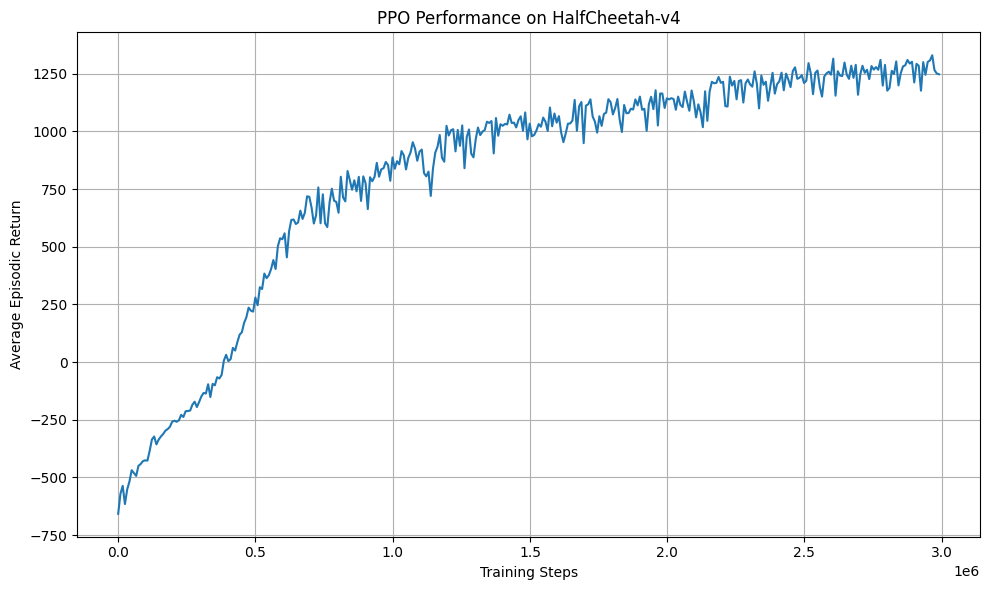

In [ ]:
if __name__ == "__main__":
    # ensure MuJoCo is installed and set before imports:
    # pip install "mujoco>=3.1.2" "gymnasium[mujoco]>=0.29.1" glfw
    # then restart, and at top of your script: os.environ["MUJOCO_GL"]="egl"

    env = "HalfCheetah-v4"
    run_params = {
        "env_id": env,
        "total_timesteps": 3_000_000,   # 2–3M typical
        "lr": 3e-4,
        "num_envs": 4,
        "num_steps": 2048,              # batch = 8192
        "update_epochs": 10,
        "clip_coef": 0.2,
        "ent_coef": 0.0,                # exploration via dynamics is enough
        "vf_coef": 0.5,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "clip_vloss": True,
        "norm_adv": True,
        "anneal_lr": True,
        "seed": 42,
        # if supported:
        # "num_minibatches": 32,        # 256 samples/mb
        # "target_kl": 0.02,
    }
    history = run_ppo(**run_params)
    steps_per_update = run_params["num_envs"] * run_params["num_steps"]
    plot_training_results(env, history, steps_per_update)


# LunarLander-v3

--- Starting PPO training for LunarLander-v3 ---
Global step: 81920, Update: 10/122
  Avg. Episodic Return: -16.58
SPS: 1015
--------------------
Global step: 163840, Update: 20/122
  Avg. Episodic Return: 1.38
SPS: 1006
--------------------
Global step: 245760, Update: 30/122
  Avg. Episodic Return: -37.41
SPS: 1008
--------------------
Global step: 327680, Update: 40/122
  Avg. Episodic Return: 47.24
SPS: 997
--------------------
Global step: 409600, Update: 50/122
  Avg. Episodic Return: 95.89
SPS: 989
--------------------
Global step: 491520, Update: 60/122
  Avg. Episodic Return: 185.89
SPS: 995
--------------------
Global step: 573440, Update: 70/122
  Avg. Episodic Return: 171.44
SPS: 995
--------------------
Global step: 655360, Update: 80/122
  Avg. Episodic Return: 138.85
SPS: 994
--------------------
Global step: 737280, Update: 90/122
  Avg. Episodic Return: 178.34
SPS: 999
--------------------
Global step: 819200, Update: 100/122
  Avg. Episodic Return: 183.40
SPS: 997
---

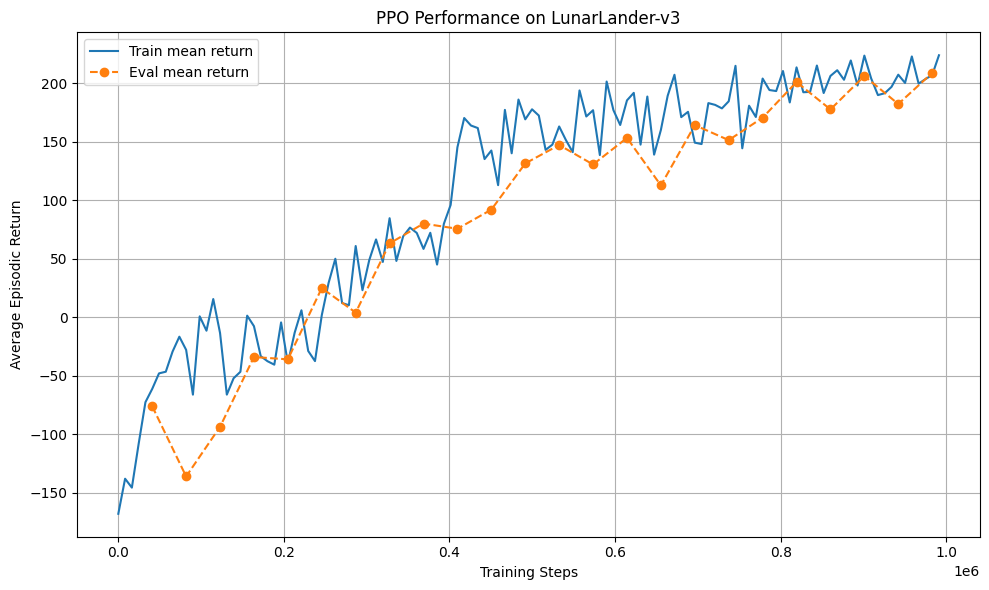

In [ ]:
if __name__ == "__main__":
    env = "LunarLander-v3"   # requires: pip install "gymnasium[box2d]"
    run_params = {
        "env_id": env,
        "total_timesteps": 1_000_000,
        "lr": 3e-4,
        "num_envs": 8,
        "num_steps": 1024,          # batch = 8192
        "update_epochs": 10,
        "clip_coef": 0.2,
        "ent_coef": 0.01,           # keep exploration (discrete)
        "vf_coef": 0.5,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "clip_vloss": True,
        "norm_adv": True,
        "anneal_lr": True,
        "seed": 42,
        # eval controls (new):
        "eval_every_updates": 5,
        "eval_episodes": 5,
    }
    train_hist, eval_hist = run_ppo(**run_params)
    steps_per_update = run_params["num_envs"] * run_params["num_steps"]
    plot_training_and_eval(env, train_hist, eval_hist, steps_per_update)
